# Modeling and Simulation in Python

Chapter 11

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import matplotlib.pyplot as plt

S (Susceptible): People who can catch the disease.
I (Infected): People who have the disease and can spread it.
R (Recovered): People who had the disease and are now immune.


### SIR implementation

We'll use a `State` object to represent the number (or fraction) of people in each compartment.

In [2]:
init = State(S=89, I=1, R=0)

S    89
I     1
R     0
Name: state, dtype: int64

To convert from number of people to fractions, we divide through by the total.

In [3]:
init /= sum(init)

S    0.988889
I    0.011111
R    0.000000
Name: state, dtype: float64

`make_system` creates a `System` object with the given parameters.

In [4]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

Here's an example with hypothetical values for `beta` and `gamma`.

In [5]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

namespace(init=S    0.988889
               I    0.011111
               R    0.000000
               Name: state, dtype: float64,
          t0=0,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

The update function takes the state during the current time step and returns the state during the next time step.

In [6]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

To run a single time step, we call it like this:

In [7]:
state = update_func(init, 0, system)

S    0.985226
I    0.011996
R    0.002778
Name: state, dtype: float64

Now we can run a simulation by calling the update function for each time step.

In [8]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        
    return state

The result is the state of the system at `t_end`

In [9]:
run_simulation(system, update_func)

S    0.520453
I    0.000615
R    0.478933
Name: state, dtype: float64

**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

Hint: what is the change in `S` between the beginning and the end of the simulation?

In [10]:
# Solution goes here
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

tc = 4     # time between contacts in days 
tr = 5     # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        
    return state


result14w=run_simulation(system, update_func)

S    0.609458
I    0.004450
R    0.386091
Name: state, dtype: float64

In [11]:
system.init['S']-result14w['S']

0.379430429899261

It looks like about 38% of people infected after 14 weeks. 

### Using TimeSeries objects

If we want to store the state of the system at each time step, we can use one `TimeSeries` object for each state variable.

In [12]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, t, system)
        S[t+1], I[t+1], R[t+1] = state
    
    return S, I, R

Here's how we call it.

In [13]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
S, I, R = run_simulation(system, update_func)

And then we can plot the results.

In [14]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plt.plot(S, '--', label='Susceptible')
    plt.plot(I, '-', label='Infected')
    plt.plot(R, ':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's what they look like.

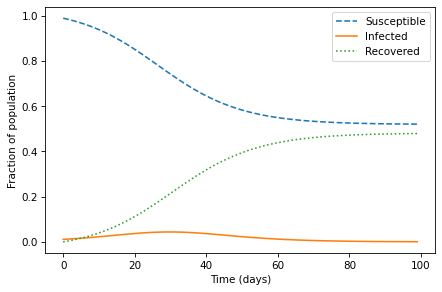

In [15]:
plot_results(S, I, R)
#savefig('figs/chap11-fig01.pdf')

### Using a DataFrame

Instead of making three `TimeSeries` objects, we can use one `DataFrame`.

We have to use `row` to selects rows, rather than columns.  But then Pandas does the right thing, matching up the state variables with the columns of the `DataFrame`.

In [16]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    

    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
        
    
    return frame

Here's how we run it, and what the result looks like.

In [17]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)



namespace(init=S    0.988889
               I    0.011111
               R    0.000000
               Name: state, dtype: float64,
          t0=0,
          t_end=98,
          beta=0.3333333333333333,
          gamma=0.25)

In [18]:
results = run_simulation(system, update_func)
results.head()

,S,I,R
0.0,0.988889,0.011111,0.000000
1.0,0.985226,0.011996,0.002778
2.0,0.981287,0.012936,0.005777
3.0,0.977055,0.013934,0.009011
4.0,0.972517,0.014988,0.012494


We can extract the results and plot them.

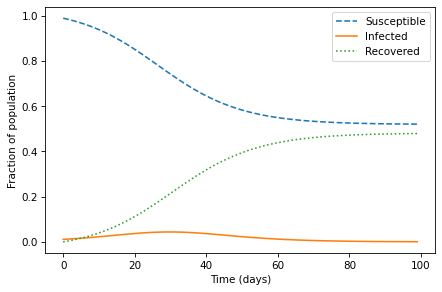

In [19]:
plot_results(results.S, results.I, results.R)

## Exercises

**Exercise**  Suppose the time between contacts is 4 days and the recovery time is 5 days.  Simulate this scenario for 14 weeks and plot the results.

            S         I         R
0.0  0.988889  0.011111  0.000000
1.0  0.986142  0.011636  0.002222
2.0  0.983273  0.012177  0.004549
3.0  0.980280  0.012735  0.006985
4.0  0.977159  0.013309  0.009532


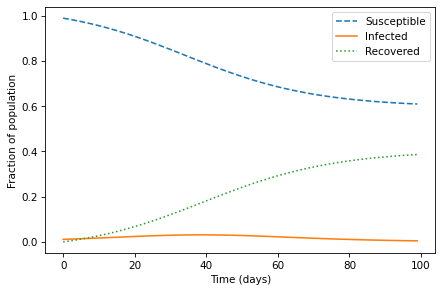

In [20]:
# Solution goes here

tc = 4     # time between contacts in days 
tr = 5     # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per 

system = make_system(beta, gamma)
results14wts = run_simulation(system, update_func)
print(results14wts.head())
plot_results(results14wts.S, results14wts.I, results14wts.R)